# Support Vector Machines (SVM)

## Configurações

A célula abaixo define funções que iremos usar para exibir nossos dados. Você pode ignorá-la. (Mas lembre-se de executar)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_points(classe1, classe2, y_values = None, x_values = None):

  # Visualizando os dados
  plt.scatter(classe1[:, 0], classe1[:, 1], color='red', label='Classe 0')
  plt.scatter(classe2[:, 0], classe2[:, 1], color='blue', label='Classe 1')
  plt.legend()
  plt.xlabel('X1')
  plt.ylabel('X2')
  plt.title('Dados de Treinamento')

  if y_values is not None:
    plt.plot(x_values, y_values, color='black', linestyle='--', label='Fronteira de Decisão')
  plt.grid(True)
  plt.show()

def plot_svm_decision_boundary(red_points, blue_points, weights, bias):
    """
    Plot points, decision boundary, and margin for a 2D SVM.

    Parameters:
    - red_points: numpy array of shape (n_red, 2), points for the red class
    - blue_points: numpy array of shape (n_blue, 2), points for the blue class
    - weights: numpy array of shape (2,), weights of the SVM
    - bias: float, bias of the SVM
    """
    # Create a figure
    plt.figure(figsize=(8, 6))

    # Plot the red and blue points
    plt.scatter(red_points[:, 0], red_points[:, 1], color='red', label='Classe 0')
    plt.scatter(blue_points[:, 0], blue_points[:, 1], color='blue', label='Classe 1')

    # Create a grid to evaluate the decision boundary
    x_min, x_max = min(torch.min(red_points[:, 0]), torch.min(blue_points[:, 0])) - 1, \
                   max(torch.max(red_points[:, 0]), torch.max(blue_points[:, 0])) + 1
    y_min, y_max = min(torch.min(red_points[:, 1]), torch.min(blue_points[:, 1])) - 1, \
                   max(torch.max(red_points[:, 1]), torch.max(blue_points[:, 1])) + 1

    xx = np.linspace(x_min, x_max, 500)
    yy = -(weights[0] * xx + bias) / weights[1]
    margin_up = -(weights[0] * xx + bias + 1) / weights[1]
    margin_down = -(weights[0] * xx + bias - 1) / weights[1]

    # Plot the decision boundary and margins
    plt.plot(xx, yy, 'k-', label='Decision Boundary')
    plt.plot(xx, margin_up, 'k--', label='Margem')
    plt.plot(xx, margin_down, 'k--')

    # Customize plot
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("SVM Decision Boundary and Margin")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

def plot_decision_boundary_kernel_binary(model, X, y, kernel):
    # Definir os limites da grade
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Calcular as predições na grade
    X_grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
    Z = model.forward(X_grid).detach().numpy().reshape(xx.shape)

    # Transformar as predições para classes binárias (-1 e +1)
    Z_binary = np.where(Z > 0, 1, -1)

    # Criar o gráfico com cores binárias
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z_binary, levels=[-1, 0, 1], colors=['lightblue', 'lightcoral'], alpha=0.8)
    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=1)  # Linha da fronteira
    plt.scatter(X[:, 0], X[:, 1], c=y.numpy().ravel(), cmap='bwr', edgecolors='k')
    plt.title(f"Fronteira de Decisão")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid()
    plt.show()




## 1. Introdução

Na aula de hoje iremos entender o que são as Support Vector Machines, o que as tornam um algoritmo tão poderoso de Apredizado de Máquina, e quais são as suas limitações.

> Objetivos
> - Entender o que são os SVMs
> - Implementar um SVM em pytorch.
> - Usar o truque do kernel para resolver problemas não lineares.
> - Explorar o SVM em uma tarefa de geologia.

### 1.1. Fronteira de Decisão

O conjunto de pontos a seguir está dividido em duas classes, a vermelha e a azul.

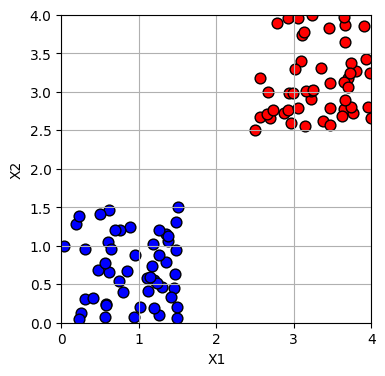

Como vimos na última aula, podemos usar uma regressão linear para classificar os pontos em suas respectivas classes. Para isso, basta encontrar uma reta que separa os dois grupos em regiões distintas do plano. Como mostrado abaixo.

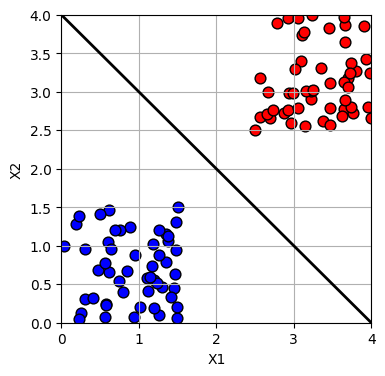

A linha encontrada pelo nosso modelo é o que chamamos de **fronteira de decisão**. Mas, como sabemos qual fronteira de decisão devemos escolher entre as infinitas possibilidades? A imagem abaixo mostra uma outra fronteira que ainda divide perfeitamente as duas classes, mas... Ela não parece pior?

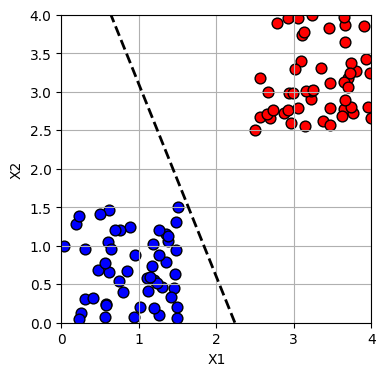

Usando uma regressão linear simples, nós não temos controle sobre qual fronteira de decisão encontraremos, e é pensando nisso que o SVM surgiu! A ideia dele é muito simples: vamos tentar encontrar a fronteira de decisão que esteja o mais longe possível de qualquer ponto. Isto é, queremos **Maximizar o tamanho da margem** em torno de nossa fronteira de decisão.

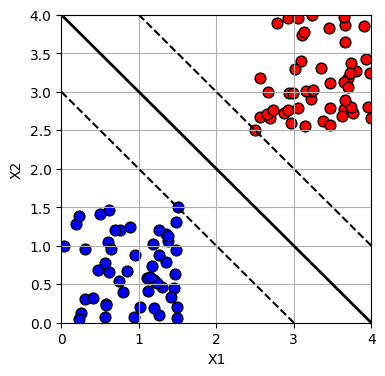

### 1.2. O SVM

Ok, o objetivo do SVM é encontrar uma fronteira de decisão com uma margem máxima, mas... O que exatamente é a margem?

Nós chamamos de margem a distância mínima entre a fronteira de decisão e o ponto mais próximo de cada classe, que são chamados de **vetores de suporte**. Ao maximizar esta distância o SVM busca uma separação que não apenas divide as classes, mas é também mais robusta a pequenas variações e generaliza melhor para novos dados.



Relembrando a última aula, o nosso SVM deve encontrar um hiperplano que separa os nossos dados, que é dado pela seguinte fórmula:


$$
w^\top x + b = 0
$$

> Lembre-se também que a predição do modelo, $\hat{y}$, é dada por $\hat{y}=w^\top x + b$


onde w, os pesos de nosso modelo, definem um vetor normal(perpendicular) ao hiperplano. Lembre-se, também, que para encontrar a classe de um ponto, temos:


> - Se $\hat{y} > 0 $, classificamos o ponto como pertencente à classe $ +1 $.
> - Se $ \hat{y}< 0 $, classificamos o ponto como pertencente à classe $-1 $.

Podemos simplificar essa formulação multiplicando $ \hat{y} $ por $y_i$ para chegar em:


$$ y_i*\hat{y} ≥ 0 $$


Com isso, nosso modelo consegue classificar os pontos corretamente. Mas, como adicionamos a margem? Bom, para isso, queremos uma 'folga' (que chamamos de margem funcional) em nossa classificação dos pontos, ou seja, queremos ter:


$$ y_i*\hat{y} ≥ γ $$


> por simplicidade, usamos $γ=1$.

Intuitivamente, perceba que, com essa pequena mudança, nosso modelo deve ser mais confiante em sua predição, ou seja, suas predições devem ficar mais distantes do hiperplano. Mas como isso ocorre na prática?

Para calcular a distância geométrica real entre um ponto qualquer e o nosso hiperplano, usamos a seguinte fórmula:


$$
M_i = \frac{\lvert \hat{y} \rvert}{\|w\|}
$$


> $||w||$ é a norma euclidiana (L2) do nosso vetor $w$
>
> Como $y_i$ pode ser apenas 1 ou -1, $|\hat{y}| =  y_i*\hat{y}$ (assumindo $y_i=\hat{y}$)

Note que aumentando o valor de $ y_i*\hat{y}$ a distância do nosso ponto ao hiperplano também aumenta! E mais do que isso, como definimos $γ=1$, temos que a menor distância possível de algum ponto é dada por:


$$
M_i = \frac{1}{\|w\|}
$$


Ou seja, para maximizar o tamanho da margem, basta minimizar a norma do nosso vetor de pesos!

E assim definimos nosso SVM, queremos minimizar:


$$
\frac{1}{2} \|w\|^2
$$

**Sujeito a:**

$$
y_i (w^\top x_i + b) \geq 1, \forall i
$$


> Intuitivamente, queremos minimizar a norma dos pesos (maximizar a margem), desde que não erremos a classificação de nenhum ponto.
>
> Fazemos $\frac{1}{2} \|w\|^2 $ pois é uma derivada mais simples de ser calculada que $||w||$





### 1.3. Hinge Loss

Na prática, ao implementar um SVM, fazemos esa otimização por meio da chamada **Hinge Loss**.

$$
\mathcal{L}_{Hinge}=max(0,1-y_i *\hat{y})
$$

Intuitivamente, a hinge loss pune os pontos classificados erroneamente, ou aqueles que estão muito próximos do hiperplano.

> Quando $ y_i * \hat{y} \geq 1 $:
>
> - A perda é **zero**, porque o ponto está no lado correto e fora da margem.
> - Isso significa que o modelo "ignora" pontos que estão bem classificados.
>
> Quando $y_i * \hat{y} < 1 $:
>
> - A perda aumenta linearmente à medida que o ponto se aproxima ou ultrapassa o hiperplano.
> - Quanto menor $y_i * \hat{y}$, maior é a penalidade.

A função de perda completa que usaremos ao treinar o nosso SVM será, portanto,

$$
\mathcal{L}_{SVM} =\frac{1}{2} \|w\|^2 + C\sum_{i=1}^N \mathcal{L}_{Hinge}(y_i , \hat{y})
$$

> O parâmetro C controla o quanto o SVM será tolerante a erros de classificação.
> - Com um C baixo, o modelo favorece o encontro de uma margem grande, em detrimento da classificação correta.
> - Com um C alto, o modelo favorece a classificação dos pontos, em detrimento da margem.


## Exercício 1: Implementando um SVM

O código abaixo define um conjunto simples de dados.

In [ ]:
import numpy as np
import torch

classe1 = torch.tensor([
    (2.0, 2.0), (2.8, 2.6), (1.8, 2.5), (1.5, 1.5), (3.0, 1.8),
    (2.3, 2.8), (3.2, 2.3), (2.5, 2.8), (1.9, 1.9), (4.3, 3)])

classe2 = torch.tensor([
    (4.0, 4.5), (5.2, 5.0), (5, 3.2), (5.5, 4.8), (4.8, 3.5),
    (6.2, 3.3), (5.0, 4.5), (4.3, 5.2), (5.7, 3.1), (4.9, 4.0)])

X = torch.cat([classe1, classe2])
y = torch.cat([torch.zeros(10)-1, torch.ones(10)]).unsqueeze(1)

plot_points(classe1, classe2)

Usando pytorch, faça um SVM usando a função de perda descrita acima.

In [ ]:

class SVM(torch.nn.Module):
    '''
      Em pytorch, os nossos modelos são geralmente compostos de um (ou vários) módulos.
      Para definir um módulo, crie uma classe e herde de torch.nn.Module, como feito acima.
    '''
    def __init__(self):
        '''
          A função __init__ é onde nós vamos inicializar o nosso modelo.
          Nela, nós vamos definir as camadas (ou operações) que nossa rede deve fazer.
        '''
        super(SVM, self).__init__() # Aqui, estamos chamando a função __init__ de noss classe pai (torch.nn.Module)

        # Faça aqui. Defina as operações de nosso modelo.
        # Dica: use 1 camada linear do pytorch.

    def forward(self, x):
        '''
          A função forward é onde definimos a ordem das operações que a nossa rede realizará.
          Ao chamá-la, nossa rede receberá a entrada (x), e gerará a saída.
        '''

        # Faça aqui. Passe x pela nossa camada linear e retorne o resultado.
         



# Função de perda Hinge
def hinge_loss(y_pred, y_true):
    
    # Faça aqui. Implemente a hinge loss conforme a fórmula decrita acima

    

def svm_loss(y_pred, y_true, w, C):
  # Faça aqui. Defina a loss total de nosso modelo conforme a modelegem explicada acima.
  # Dica: use a função hinge_loss implementada acima.
  




O código abaixo define um loop de treino padrão no pytorch. Preste atenção em como ele é estruturado.

> Observação: A implementação feita neste notebook difere do SVM clássico. Aqui, estamos modelando o SVM de uma maneira mais semelhante a uma rede neural, com o objetivo de começar a nos familiarizarmos com o funcionamento do PyTorch. Nesta abordagem, usamos uma camada linear do PyTorch e otimizamos a função de perda usando Gradiente Descendente. Embora esta implementação capture os princípios fundamentais do SVM, como a maximização da margem e a penalização de erros de classificação através da Hinge Loss, ela não é idêntica à implementação clássica, que resolve o problema de otimização convexa diretamente usando métodos como programação quadrática ou o algoritmo SMO.
>
> Optamos por esta implementação para facilitar o entendimento e permitir que vocês ganhem experiência prática com o PyTorch, preparando-os para o restante do curso.

In [ ]:
# Treinar o modelo
num_epochs = 2000
C = 10  # Regularização

# Inicializando o modelo
model = SVM()

# Para facilitar, vamos usar o gradiente descendente já pronto do pytorch
# Para inicializá-lo, basta passar os parâmetros da rede a serem aprendidos, e a taxa de aprendizado.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(num_epochs):

    model.train() # Colocando o modelo em modo de treino
    optimizer.zero_grad() # Zerando os gradientes acumulados de iterações anteriores

    # Chamando a função forward de nosso modelo. Ela nos retornará as predições.
    y_pred = model(X)

    # Calculando a perda
    loss = svm_loss(y_pred, y, model.linear.weight, C)

    loss.backward() # A chamada backward calcula os gradientes de nossa loss para que atualziar os pesos de nosso modelo.
    optimizer.step() # A chamada step, do otimizador, atualiza os pesos com base nos gradientes.


    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f'Época {epoch+1}/{num_epochs}, Perda: {loss.item():.4f}')


In [ ]:
plot_svm_decision_boundary(classe1, classe2, model.linear.weight[0].detach(), model.linear.bias[0].item())

Agora varie o valor de C. O que acontece com o modelo quando: C = 0.1, C = 1, C = 10 e C = 100?


## 2. O Truque do Kernel

Assim como vimos na aula de regressão linear, o SVM, tal como apresentado até agora, é incapaz de representar dados que não sejam linearmente separáveis. Na aula passada, resolvemos esse problema utilizando **features polinomiais**, que nos permitiram modelar relações não lineares ao expandir a dimensionalidade de nossas entradas.

No entanto, ao aumentar a dimensionalidade explicitamente, podemos enfrentar problemas de alta dimensionalidade e aumento significativo do custo computacional. É aqui que entra o Truque do Kernel.

De forma simples, o SVM nos permite mapear os nossos dados **implicitamente** para uma dimensão maior, onde eles se tornam linearmente separáveis.



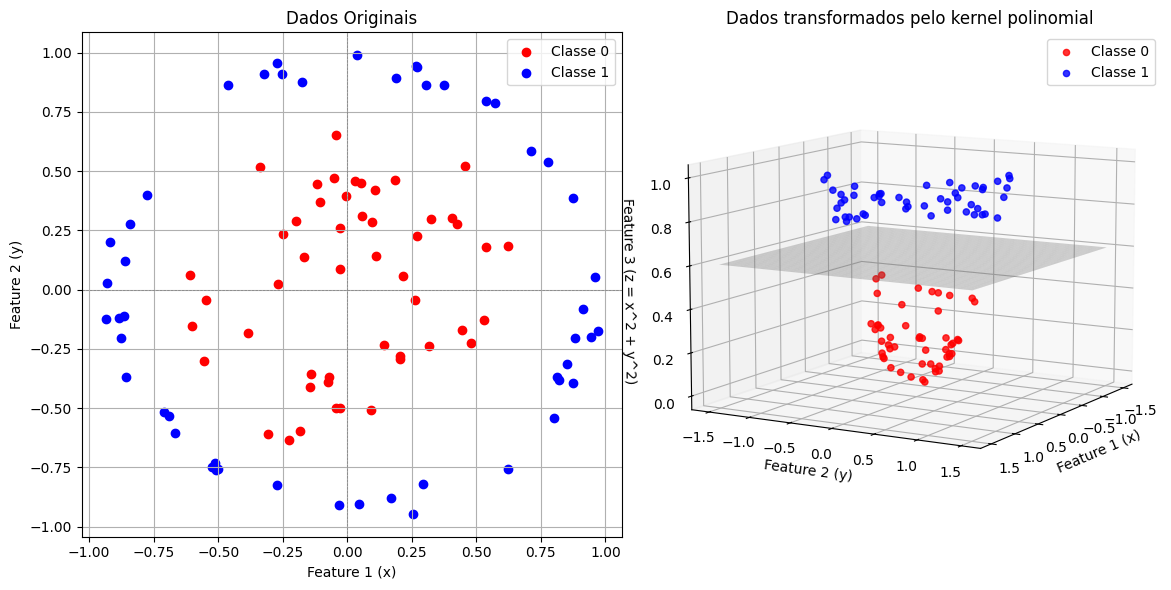

### 2.1. O que é o Truque do Kernel?


O SVM padrão é basicamente um produto interno entre as features de entrada e os pesos aprendidos. A ideia por trás do truque do kernel pe bastante simples: e se pudéssemos, de algum jeito, mapear esse produto interno para um espaço com mais dimensões **sem alterar diretamente as nossas features**?

Para isso, em nosso modelo, agora iremos substituir esse produto interno padrão por uma função de kernel (que será definida mais abaixo), que representa o produto interno em um espaço de dimensão superior. Isso significa que, ao treinar o SVM com um kernel, estamos efetivamente encontrando um hiperplano que separa os dados em um espaço de alta dimensão, mas sem nunca precisar manipular diretamente as coordenadas nesse espaço.

O Truque do Kernel é uma técnica que permite que algoritmos baseados em produto interno (como o SVM) operem em um espaço de características de alta dimensão sem precisar computar explicitamente as novas features. Em vez disso, usamos uma função de kernel que calcula diretamente o produto interno no espaço transformado.

Quando usamos um kernel, substituímos esse produto interno padrão por uma função de kernel que representa o produto interno em um espaço de dimensão superior.

Isso significa que, ao treinar o SVM com um kernel, estamos efetivamente encontrando um hiperplano que separa os dados em um espaço de alta dimensão, mas sem nunca precisar manipular diretamente as coordenadas nesse espaço.

## 2.2. Matemática do Truque do Kernel no SVM

Podemos reformular o SVM para que ele toma decisões baseadas no **produto interno** entre os dados de entrada ($x_i$) e os vetores de suporte ($x_j$):

$$\hat{y} = \sum_{j=1}^N \alpha_j y_j (x_i \cdot x_j) + b$$

### Aqui:
- $\alpha_j$ são os coeficientes aprendidos pelo modelo.
- $y_j$ é o rótulo do vetor de suporte ($+1$ ou $-1$).
- $x_i \cdot x_j$ é o produto interno entre os vetores de entrada.

> Essa nova formulação é chamada de formulação dual, e pode ser derivada facilemnte a partir da forma primal, $\hat{y}=w⋅x+b$. A forma dual é importante no contexto do truque do kernel, pois nos permite realizar predições diretamente nos vetores de suporte.


Quando usamos o **truque do kernel**, substituímos o produto interno $x_i \cdot x_j$ por uma **função de kernel** $K(x_i, x_j)$. Essa função calcula diretamente o produto interno em um espaço de alta dimensão, sem precisar transformar explicitamente os dados para lá.

Um dos mais comums e simples kernels que podemos usar no SVM é o polinomial.
O kernel polinomial é dado por:

$$K(x_i, x_j) = (x_i \cdot x_j + c)^d$$

#### Aqui:
- $c$ é uma constante que controla o deslocamento.
- $d$ é o grau do polinômio.

O kernel polinomial corresponde a uma **transformação implícita** que considera combinações de termos até o grau $d$. Por exemplo:

Se $d = 2$, a transformação seria algo como:

$$[x_1^2, x_2^2, x_1 x_2, x_1, x_2, 1]$$

Com o kernel, calculamos diretamente $K(x_i, x_j)$ sem precisar computar explicitamente todas essas combinações. Isso economiza recursos computacionais e permite trabalhar com transformações de alta dimensão de forma eficiente.


## Exercício 2. Kernel Polinomial

Primeiro, vamos criar alguns dados não linearmente separáveis.

In [ ]:
from sklearn.datasets import make_moons

# Gerar dados não linearmente separáveis
X, y = make_moons(noise = 0.2)
print(y)
y = np.where(y == 0, -1, 1)  # Converter rótulos para -1 e 1


# Visualizar os dados
plot_points(X[y == 1], X[y == -1])

X = torch.tensor(X).float()
y = torch.tensor(y).float()


Aqui vamos definir um modelo de SVM que aceite diferentes kernels.

In [ ]:
class KernelSVM(torch.nn.Module):
    def __init__(self, kernel, X, y):
        super(KernelSVM, self).__init__()
        self.kernel = kernel  # Função de kernel
        self.X = X  # Vetores de suporte (Considerar todo X como um vetro de suporte não é eficiente, mas servirá aqui)
        self.y = y # Adicionando uma dimensão a mais em y

        self.alpha = torch.randn(len(y), requires_grad=True)  # Coeficientes Lagrange
        self.bias = torch.randn(1, requires_grad=True)  # Viés

    def forward(self, X_new):
        """
        Calcula as predições para os novos pontos X_new.
        """
        # Calcula a matriz kernel entre os vetores de suporte e os novos pontos
        K = self.kernel(self.X, X_new)  # Shape: (n_support_vectors, n_new_points)

        # Calcula o vetor de predições
        weighted_support = self.alpha * self.y  # Shape: (n_support_vectors,)
        predictions = K.T @ weighted_support + self.bias  # Shape: (n_new_points,)
        return predictions

Agora é sua vez! Complete a função abaixo para fazer um kernel polinomial.

In [ ]:
class PolynomialKernel(torch.nn.Module):
    def __init__(self, degree=3, c=1):
        """
        Classe para calcular o kernel polinomial.
        Args:
        - degree: grau do polinômio.
        - c: constante para deslocamento.
        """
        super(PolynomialKernel, self).__init__()
        self.degree = degree
        self.c = c

    def forward(self, X1, X2):
        """
        Calcula a matriz de kernel.
        Args:
        - X1: matriz de dados (N x d)
        - X2: matriz de dados (M x d)

        Returns:
        - Kernel matrix (N x M)
        """
        # Faça aqui. Complete essa função para criar um kernel polinomial. 
         

Agora escreva a função de treino para o novo modelo.
> Dica: se baseie no exemplo do exercício 1.

In [ ]:
kernel = PolynomialKernel(degree=3)
model = KernelSVM(kernel=kernel, X=X, y=y)


In [ ]:
plot_decision_boundary_kernel_binary(model, X, y, kernel)

Varie o grau do kernel, o que acontece com o seu modelo?


## Desafio: SVM na prática

Vamos agora explorar e testar outros kernels e comparar os resultados obtidos para um problema real.

O dataset **Sonar** é um conjunto de dados utilizado para classificar objetos como sendo "rocha" ou "mina" com base em medições de sinais sonares. Ele contém informações obtidas a partir de 60 variáveis numéricas que representam as amplitudes do retorno do sinal sonar em diferentes frequências.

> Fonte: UCI Machine Learning Repository.
>
> **Características**: 60 variáveis preditivas contínuas, como:
> - Intensidade do sinal refletido em diferentes frequências.
>
> **1 variável alvo**: tipo de objeto:
> - "R" (Rock - rocha)
> - "M" (Mine - mina)
>
> **Tarefa**: Classificação binária (R = rocha, M = mina).

Este dataset é frequentemente usado para avaliar algoritmos de classificação, especialmente em contextos com dados numéricos e não linearmente separáveis.

> https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks

Você deve testar diferentes kernels para o SVM e comparar o seus resultados. Para facilitar o trabalho, use a implementação do SVM da biblioteca scikit-learn.

> Além do kernel polinomial, o scikit-learn também já tem implementados os seguintes kernels:
>
> #### Kernel Linear:
> - **Fórmula:**  
>   $$K(x_i, x_j) = x_i^\top x_j$$
> - **Uso:** Adequado quando os dados são aproximadamente linearmente separáveis.
> - **Características:** Simples e eficiente. Não transforma o espaço dos dados.
>
> #### Kernel RBF (Radial Basis Function):
> - **Fórmula:**  
>   $$K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)$$
> - **Parâmetros:**  
>   - $\gamma$: Parâmetro que define a largura da função Gaussiana.
> - **Uso:** Quando a relação entre classe e features é altamente não linear.
> - **Características:** Pode modelar relações complexas; é o kernel padrão em muitos casos.
>
> #### Kernel Sigmoidal:
> - **Fórmula:**  
>   $$K(x_i, x_j) = \tanh(\gamma x_i^\top x_j + r)$$
> - **Parâmetros:**  
>   - $\gamma$: Controla a escala do produto interno.  
>   - $r$: Termo de deslocamento.
> - **Uso:** Similar à função de ativação em redes neurais.
> - **Características:** Menos usado em SVMs; pode ser útil em casos específicos.


### Instruções



1) Processe os dados:

> - Transforme as labels em -1 e 1
> - Normalize (se necessário)
>   - Algumas SVMs (como com kernel RBF) são sensíveis à escala das variáveis. Padronize os dados se necessário por meio de um **standadiztion**.
>   - https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html

2)Divida os Dados:

> - Separe o conjunto de dados em treino e teste (70% para treino e 30% para teste).
>   - https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html
> > Os conjuntos de treino, teste e validação serão melhor explicados na próxima aula, por enquanto, apenas aprenda a usar a função acima.

3) Experimente Diferentes Kernels:

> - Use o SVC do scikit-learn com os seguintes kernels: linear, poly, rbf, sigmoid.
>   - https://scikit-learn.org/dev/modules/generated/sklearn.svm.SVC.html
> - Compare os resultados em termos de acurácia, matriz de confusão e relatório de classificação.
>   - https://scikit-learn.org/dev/api/sklearn.metrics.html

4) Compare os Resultados:

> - Qual Kernel apresentou o melhor resultado?

In [ ]:
import pandas as pd

# Carregando os dados
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
column_names = [f'Feature_{i}' for i in range(1, 61)] + ['Label']
data = pd.read_csv(url, header=None, names=column_names)

# Separando features de labels
X = data.iloc[:, :-1]
y = data['Label']

In [ ]:
# Faça aqui